## Given functions

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]




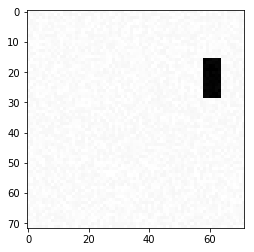

In [0]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

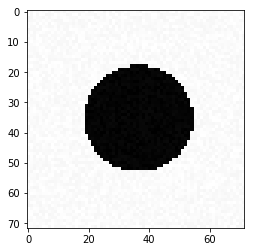

In [0]:
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

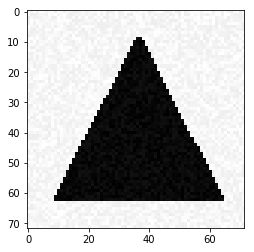

In [0]:
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

## Simple classification

### Imports

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import SGD, Adam
from keras.utils import np_utils

Using TensorFlow backend.


### Metrics

Here are some metrics we will use to train our model.


In [0]:
from keras import backend as K


def precision_threshold(threshold=0.5):
    def precision(y_true, y_pred):
        """Precision metric.
         Only computes a batch-wise average of precision.
         Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        p = true_positives / (predicted_positives + K.epsilon())
        return p

    return precision


def f1_score_threshold(threshold=0.5):
    def f1_score(y_true, y_pred, beta=1):
        """Computes the F score.
         The F score is the weighted harmonic mean of precision and recall.
        Here it is only computed as a batch-wise average, not globally.
         This is useful for multi-label classification, where input samples can be
        classified as sets of labels. By only using accuracy (precision) a model
        would achieve a perfect score by simply assigning every class to every
        input. In order to avoid this, a metric should penalize incorrect class
        assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
        computes this, as a weighted mean of the proportion of correct class
        assignments vs. the proportion of incorrect class assignments.
         With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
        correct classes becomes more important, and with beta > 1 the metric is
        instead weighted towards penalizing incorrect class assignments.
        """
        threshold_value = threshold
        if beta < 0:
            raise ValueError('The lowest choosable beta is zero (only precision).')
        # If there are no true positives, fix the F score at 0 like sklearn.
        if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
            return 0
        precision = precision_threshold(threshold_value)
        recall = recall_threshold(threshold_value)
        p = precision(y_true, y_pred)
        r = recall(y_true, y_pred)
        bb = beta ** 2
        fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
        return fbeta_score

    return f1_score


def recall_threshold(threshold=0.5):
    def recall(y_true, y_pred):
        """Recall metric.
         Only computes a batch-wise average of recall.
         Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        r = true_positives / (possible_positives + K.epsilon())
        return r

    return recall


def get_metrics(threshold):
    return {
        'precision': precision_threshold(threshold=threshold),
        'recall': recall_threshold(threshold=threshold),
        'f1_score': f1_score_threshold(threshold=threshold)
    }


### Model compilation
We create a function to create a simple Sequential Dense model with given parameters

In [0]:
def get_model(optimizer, loss, metrics):
  """
  Creates then compiles a model and returns it.
  The model is very simple : One input layer followed by one Dense layer.
  """
  model = Sequential()
  # We use a Dense layer with 3 neurons in order to match the labels's shape.
  # Softmax activation to get an output range of [0, 1]
  model.add(Dense(3, activation='softmax', input_shape=(IMAGE_SIZE*IMAGE_SIZE,)))
  
  model.compile(optimizer=optimizer,
               loss=loss,
               metrics=metrics)
  model.summary()
  return model

### Train and validation data
We get the data for training and validation. Then we change labels to get an array of 3 element in range of [0, 1]

In [0]:
[X_train, Y_train] = generate_dataset_classification(300, 20)
[X_valid, Y_valid] = generate_dataset_classification(60, 20)
Y_train = np_utils.to_categorical(Y_train)
Y_valid = np_utils.to_categorical(Y_valid)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Creating data:
0
10
20
30
40
50


### Model training

#### Stochastic gradient descent
We train our model with SGD.
We use an important number of epochs because our learning rate is small (in order to avoid oscillations around a minimum).

In [0]:
optimizer = SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False) # 0.001 learning rate without modifications during gradient descent
loss = 'binary_crossentropy'
metrics = [get_metrics(0.5)['precision'], get_metrics(0.5)['recall'], get_metrics(0.5)['f1_score']]

model_sgd = get_model(optimizer, loss, metrics)

history_sgd = model_sgd.fit(X_train, Y_train,
          epochs=3000,
          batch_size=64,
          validation_data=(X_valid, Y_valid)
         )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 15555     
Total params: 15,555
Trainable params: 15,555
Non-trainable params: 0
_________________________________________________________________
Train on 300 samples, validate on 60 samples
Epoch 1/3000
300/300 [==============================] - 1s 3ms/step - loss: 0.7741 - precision: 0.2269 - recall: 0.1167 - f1_score: 0.1501 - val_loss: 0.7743 - val_precision: 0.2593 - val_recall: 0.1167 - val_f1_score: 0.1609
Epoch 2/3000
300/300 [==============================] - 0s 121us/step - loss: 0.7503 - precision: 0.3023 - recall: 0.0833 - f1_score: 0.1293 - val_loss: 0.7543 - val_precision: 0.2500 - val_recall: 0.0667 - val_f1_score: 0.1053
Epoch 3/3000
300/300 [==============================] - 0s 122us/step - loss: 0.7371 - precision: 0.1737 - recall: 0.0267 - f1_score: 0.0456 - val_loss: 0.7438 - val_p

We now plot the training history.

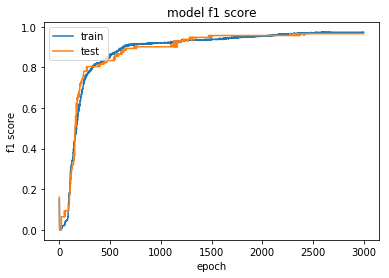

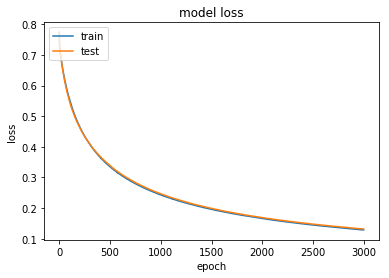

In [0]:
plt.plot(history_sgd.history['f1_score'])
plt.plot(history_sgd.history['val_f1_score'])
plt.title('model f1 score')
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_sgd.history['loss'])
plt.plot(history_sgd.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Adam optimizer
We train our model with Adam optimizer

In [0]:
optimizer = Adam(0.001)
loss = 'binary_crossentropy'
metrics = [get_metrics(0.5)['precision'], get_metrics(0.5)['recall'], get_metrics(0.5)['f1_score']]

model_adam = get_model(optimizer, loss, metrics)

history_adam = model_adam.fit(X_train, Y_train,
          epochs=100,
          batch_size=32,
          validation_data=(X_valid, Y_valid)
         )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 3)                 15555     
Total params: 15,555
Trainable params: 15,555
Non-trainable params: 0
_________________________________________________________________
Train on 300 samples, validate on 60 samples
Epoch 1/100
300/300 [==============================] - 1s 2ms/step - loss: 1.3109 - precision: 0.2870 - recall: 0.2800 - f1_score: 0.2831 - val_loss: 0.8754 - val_precision: 0.3496 - val_recall: 0.3333 - val_f1_score: 0.3413
Epoch 2/100
300/300 [==============================] - 0s 126us/step - loss: 0.6922 - precision: 0.5894 - recall: 0.5367 - f1_score: 0.5579 - val_loss: 0.4479 - val_precision: 0.5931 - val_recall: 0.4667 - val_f1_score: 0.5214
Epoch 3/100
300/300 [==============================] - 0s 136us/step - loss: 0.4622 - precision: 0.7333 - recall: 0.6133 - f1_score: 0.6600 - val_loss: 0.3823 - val_prec

We now plot the training history.

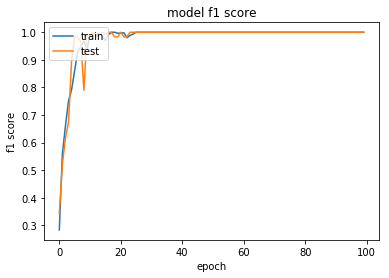

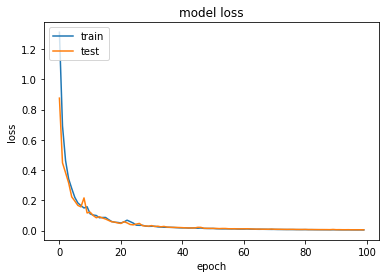

In [0]:
plt.plot(history_adam.history['f1_score'])
plt.plot(history_adam.history['val_f1_score'])
plt.title('model f1 score')
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_adam.history['loss'])
plt.plot(history_adam.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Visualization of solution

#### SGD

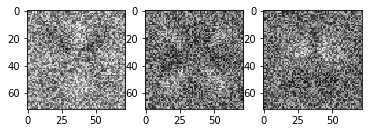

In [0]:
weights = model_sgd.get_weights()[0]
weights = weights.reshape(IMAGE_SIZE, IMAGE_SIZE, weights.shape[1])
_, [ax0, ax1, ax2] = plt.subplots(1, 3)
ax0.imshow(weights[:,:,0], cmap='gray')
ax1.imshow(weights[:,:,1], cmap='gray')
ax2.imshow(weights[:,:,2], cmap='gray')


#### Adam

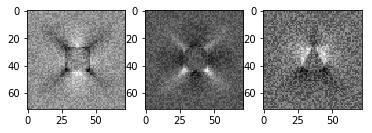

In [0]:
weights = model_adam.get_weights()[0]
weights = weights.reshape(IMAGE_SIZE, IMAGE_SIZE, weights.shape[1])
_, [ax0, ax1, ax2] = plt.subplots(1, 3)
ax0.imshow(weights[:,:,0], cmap='gray')
ax1.imshow(weights[:,:,1], cmap='gray')
ax2.imshow(weights[:,:,2], cmap='gray')

## A More Difficult Classification Problem

### Train and validation data
We generate training and validation sets with shapes of different size and positions.

In [0]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)
[X_valid, Y_valid] = generate_dataset_classification(60, 20, True)
Y_train = np_utils.to_categorical(Y_train)
Y_valid = np_utils.to_categorical(Y_valid)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Creating data:
0
10
20
30
40
50


### Test Data
We generate a test dataset to compare the models.

In [0]:
[X_test, Y_test] = generate_test_set_classification()
X_test = X_test.reshape(X_test.shape[0], IMAGE_SIZE*IMAGE_SIZE,)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


### Dense model train on moving shapes
Lets train the previous models on this new data

#### Stochastic gradient descent
We train our model with SGD

In [0]:
optimizer = SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False) # 0.001 learning rate without modifications during gradient descent
loss = 'binary_crossentropy'
metrics = [get_metrics(0.5)['precision'], get_metrics(0.5)['recall'], get_metrics(0.5)['f1_score']]

model_sgd = get_model(optimizer, loss, metrics)

history_sgd = model_sgd.fit(X_train, Y_train,
          epochs=3000,
          batch_size=64,
          validation_data=(X_valid, Y_valid)
         )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 3)                 15555     
Total params: 15,555
Trainable params: 15,555
Non-trainable params: 0
_________________________________________________________________
Train on 300 samples, validate on 60 samples
Epoch 1/3000
300/300 [==============================] - 1s 2ms/step - loss: 0.6627 - precision: 0.1269 - recall: 0.0767 - f1_score: 0.0935 - val_loss: 0.6487 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/3000
300/300 [==============================] - 0s 74us/step - loss: 0.6398 - precision: 0.1200 - recall: 0.0067 - f1_score: 0.0126 - val_loss: 0.6496 - val_precision: 0.3333 - val_recall: 0.0333 - val_f1_score: 0.0606
Epoch 3/3000
300/300 [==============================] - 0s 65us/step - loss: 0.6422 - precision: 0.2916 - recall: 0.0100 - f1_score: 0.0188 - val_loss: 0.64

We now plot the training history.

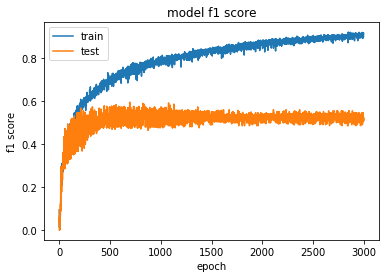

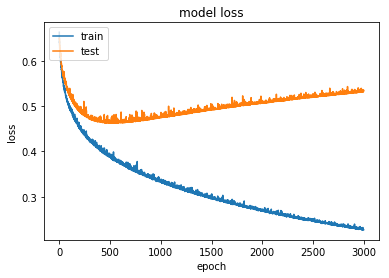

In [0]:
plt.plot(history_sgd.history['f1_score'])
plt.plot(history_sgd.history['val_f1_score'])
plt.title('model f1 score')
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_sgd.history['loss'])
plt.plot(history_sgd.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Adam optimizer
We train our model with Adam optimizer.

In [0]:
optimizer = Adam(0.001)
loss = 'binary_crossentropy'
metrics = [get_metrics(0.5)['precision'], get_metrics(0.5)['recall'], get_metrics(0.5)['f1_score']]

model_adam = get_model(optimizer, loss, metrics)

history_adam = model_adam.fit(X_train, Y_train,
          epochs=40,
          batch_size=32,
          validation_data=(X_valid, Y_valid)
         )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 3)                 15555     
Total params: 15,555
Trainable params: 15,555
Non-trainable params: 0
_________________________________________________________________
Train on 300 samples, validate on 60 samples
Epoch 1/40
300/300 [==============================] - 1s 3ms/step - loss: 1.6789 - precision: 0.3511 - recall: 0.3467 - f1_score: 0.3488 - val_loss: 1.2042 - val_precision: 0.3667 - val_recall: 0.3667 - val_f1_score: 0.3667
Epoch 2/40
300/300 [==============================] - 0s 130us/step - loss: 0.9662 - precision: 0.3547 - recall: 0.3333 - f1_score: 0.3406 - val_loss: 0.9400 - val_precision: 0.4167 - val_recall: 0.4167 - val_f1_score: 0.4167
Epoch 3/40
300/300 [==============================] - 0s 127us/step - loss: 0.8276 - precision: 0.4035 - recall: 0.3767 - f1_score: 0.3887 - val_loss: 0.6715 - val_precisi

We now plot the training history.

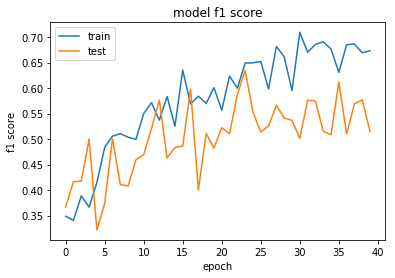

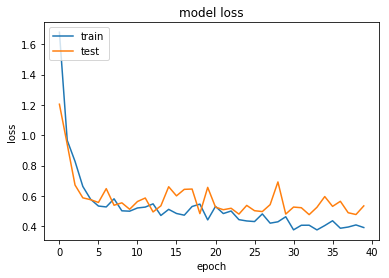

In [0]:
plt.plot(history_adam.history['f1_score'])
plt.plot(history_adam.history['val_f1_score'])
plt.title('model f1 score')
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_adam.history['loss'])
plt.plot(history_adam.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Dense models test

In [0]:
model_sgd.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 70us/step


[0.5230206135908763,
 0.5967174990971883,
 0.5366666666666666,
 0.5645968508720398]

In [0]:
model_adam.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 99us/step


[0.530429060459137, 0.5482738896210988, 0.4966666662693024, 0.5206804414590199]

Dense models are pretty weak against changing sizes and mooving shapes. That's because the network do not recognize patterns.
That is why we will use a ConvNet that is able to learn patterns.

### ConvNet compilation

In [0]:
def get_model_conv(optimizer, loss, metrics):
  model = Sequential()
  model.add(Conv2D(16, (5, 5), padding='same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  
  model.add(Flatten())
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(3, activation='softmax'))
  
  model.compile(optimizer=optimizer,
               loss=loss,
               metrics=metrics)
  model.summary()
  return model

### ConvNet training

We reshape data for ConvNet training.
New shape must be : (n_data, image_size, image_size, n_channels)

In [0]:
X_train = X_train.reshape(X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
X_valid = X_valid.reshape(X_valid.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
X_test = X_test.reshape(X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)

Now we can train our ConvNet model.

In [0]:
optimizer = Adam(0.00001)
loss = 'binary_crossentropy'
metrics = ['accuracy', get_metrics(0.5)['precision'], get_metrics(0.5)['recall'], get_metrics(0.5)['f1_score']]

model_conv = get_model_conv(optimizer, loss, metrics)

model_conv.fit(X_train, Y_train,
          epochs=500,
          batch_size=32,
          validation_data=(X_valid, Y_valid)
         )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 72, 72, 16)        416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10368)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              10617856  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
__________

### ConvNet test

In [0]:
model_conv.evaluate(X_test, Y_test)